In [ ]:
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sn
from tqdm.notebook import tqdm
 
from functools import partial
from collections import OrderedDict

In [ ]:
torch.cuda.is_available()

True

In [ ]:
print(torch.__version__)

1.8.1+cu101



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


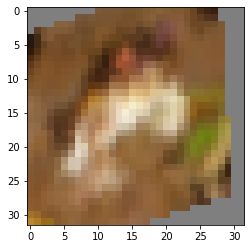

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ]
)

if True:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.GaussianBlur(kernel_size=[3,3], sigma=(0.2, 1)),
        transforms.RandomAffine(degrees=[-20, 20], translate=[0.1, 0.1], scale=[0.9, 1.1], shear=[-20, 20]),
        ])
    
 
trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=True, num_workers=2)
 
testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2)
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(trainset[0][0])

In [ ]:
classes[trainset[0][1]]

'frog'

In [ ]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
def test(net, dataloader, device='cuda:0'):
    net = net.to(device)
    conf_matrix = np.zeros((10, 10))
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            pred = net(X)
            pred_cls = pred.argmax(1)
            for j in range(len(pred_cls)):
                conf_matrix[y[j]][pred_cls[j]] += 1
    return conf_matrix

In [ ]:
def train(net, dataloader, optimizer, loss_func, epochs=100, device='cuda:0', scheduler=None):
    n = len(trainloader.dataset)
    net.to(device)
    train_acc = np.zeros(epochs)
    test_acc = np.zeros(epochs)
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in tqdm(range(epochs)):
        epoch_ok = 0
        
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = net(X)
            loss = loss_func(pred, y)
            
            train_loss[epoch] += loss.item()
            pred_cls = pred.argmax(1)
            epoch_ok += sum(pred_cls == y)
            
            loss.backward()
            optimizer.step()
        
        if scheduler: scheduler.step()
        
        conf_matrix = test(net, testloader)    
        test_acc[epoch] = np.diag(conf_matrix).sum() / np.sum(conf_matrix)
        train_acc[epoch] = epoch_ok / n
        
        print(f'Epoch {epoch}: train loss: {train_loss[epoch]:.4f}, train acc: {train_acc[epoch]:.3f}, '
              f'test acc: {test_acc[epoch]}')
    
    return  train_acc, test_acc, train_loss, test_loss

In [ ]:
class Net1(nn.Module):
    
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.gap = nn.MaxPool2d(kernel_size=(8,8))

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.linear = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.ReLU()
        )

    def forward(self, x):
        # conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool(F.relu(x))
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.gap(F.relu(x))
        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x
    

In [ ]:
class Net2(nn.Module):
    
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.conv11 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv22 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5), padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.conv33 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,5), padding=2)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.gap = nn.MaxPool2d(kernel_size=(8,8))
        
        self.linear = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.ReLU()
        )

    def forward(self, x):
        # conv block
        x = self.conv1(x)
        # x = self.conv11(F.relu(x))
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        # x = self.conv22(F.relu(x))
        x = self.pool(F.relu(x))
        x = self.conv3(x)
        # x = self.conv33(F.relu(x))
        x = self.gap(F.relu(x))
        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x
    

In [ ]:
class Net3(nn.Module):
    
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.gap = nn.MaxPool2d(kernel_size=(16, 16))
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(32, 10),
            nn.ReLU()
        )
    
    def forward(self, x):
        # conv block
        x = self.conv1(x)
        # x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        # x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        # x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        # x = self.bn4(x)
        x = F.relu(x)
        x = self.gap(x)

        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x
    

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
loss_func = nn.CrossEntropyLoss()
net = Net1().to(device)
sgd = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(sgd, step_size=10, gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [ ]:
train_acc, test_acc, train_loss, test_loss = train(net, trainloader, sgd, loss_func, 100)

Epoch 0: train loss: 2717.9914, train acc: 0.360, test acc: 0.4309
Epoch 1: train loss: 2280.1881, train acc: 0.465, test acc: 0.4958
Epoch 2: train loss: 2123.0170, train acc: 0.509, test acc: 0.5209
Epoch 3: train loss: 2013.1244, train acc: 0.534, test acc: 0.5192
Epoch 4: train loss: 1939.3367, train acc: 0.559, test acc: 0.5694
Epoch 5: train loss: 1884.1740, train acc: 0.568, test acc: 0.5764
Epoch 6: train loss: 1839.9180, train acc: 0.582, test acc: 0.5866
Epoch 7: train loss: 1794.5973, train acc: 0.590, test acc: 0.5894
Epoch 8: train loss: 1780.8748, train acc: 0.597, test acc: 0.6031
Epoch 9: train loss: 1748.8157, train acc: 0.602, test acc: 0.5876
Epoch 10: train loss: 1737.5068, train acc: 0.605, test acc: 0.5996
Epoch 11: train loss: 1707.7480, train acc: 0.612, test acc: 0.6115
Epoch 12: train loss: 1693.2839, train acc: 0.617, test acc: 0.6091
Epoch 13: train loss: 1667.6216, train acc: 0.621, test acc: 0.6176
Epoch 14: train loss: 1649.5370, train acc: 0.629, test ac

In [ ]:
train_acc2, test_acc2, train_loss2, test_loss2 = train(net, trainloader, sgd, loss_func, 100)

Epoch 0: train loss: 1346.4138, train acc: 0.698, test acc: 0.6854
Epoch 1: train loss: 1342.4395, train acc: 0.700, test acc: 0.6788
Epoch 2: train loss: 1344.0599, train acc: 0.699, test acc: 0.6847
Epoch 3: train loss: 1336.2617, train acc: 0.702, test acc: 0.6847
Epoch 4: train loss: 1339.2982, train acc: 0.701, test acc: 0.6756
Epoch 5: train loss: 1343.3447, train acc: 0.698, test acc: 0.6829
Epoch 6: train loss: 1332.3377, train acc: 0.703, test acc: 0.6842
Epoch 7: train loss: 1329.0780, train acc: 0.703, test acc: 0.6695
Epoch 8: train loss: 1325.9321, train acc: 0.703, test acc: 0.6761
Epoch 9: train loss: 1339.4044, train acc: 0.702, test acc: 0.6795
Epoch 10: train loss: 1332.9268, train acc: 0.703, test acc: 0.6755
Epoch 11: train loss: 1333.7839, train acc: 0.702, test acc: 0.6786
Epoch 12: train loss: 1332.4796, train acc: 0.703, test acc: 0.6918
Epoch 13: train loss: 1322.2180, train acc: 0.707, test acc: 0.6627
Epoch 14: train loss: 1329.0734, train acc: 0.705, test ac

In [ ]:
px.line(y=test_acc)

In [ ]:
class ResBlockSimple(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.module = module
 
    def forward(self, inputs):
        return self.module(inputs) + inputs

class ResBlockSimpleR(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.module = nn.Sequential(
                    nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(n_channels),
                    nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(n_channels),
                )
 
    def forward(self, inputs):
        return self.module(inputs) + inputs
 
 
class ResNet02(nn.Module):
    def __init__(self, classes=10, simpnet_name='ResNet02'):
        super(ResNet02, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
 
        self.residual_net = self._make_layers()
 
        self.gap = nn.MaxPool2d(kernel_size=(32, 32))
 
        self.linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 10),
            nn.ReLU()
        )
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.residual_net(x)
        x = self.gap(x)
        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x
 
    def _make_layers(self):
 
        model = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(16),
            ResBlockSimpleR(16),
            ResBlockSimpleR(16),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            ResBlockSimpleR(32),
            ResBlockSimpleR(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            ResBlockSimpleR(64),
            ResBlockSimpleR(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            ResBlockSimpleR(128),
            ResBlockSimpleR(128)
 
        )
 
        for m in model.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
 
        return model

In [ ]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red, c_out : dict, res = False):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
        """
        super().__init__()

        self.resTF = res
        self.res = nn.Conv2d(c_in, c_out["1x1"]+c_out["3x3"]+c_out["5x5"]+c_out["max"], kernel_size=1)

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            nn.ReLU()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red, kernel_size=1),
            nn.BatchNorm2d(c_red),
            nn.ReLU(),
            nn.Conv2d(c_red, c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            nn.ReLU()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red, kernel_size=1),
            nn.BatchNorm2d(c_red),
            nn.ReLU(),
            nn.Conv2d(c_red, c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            nn.ReLU()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            nn.ReLU()
        )


    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)

        if self.resTF:
            residal = self.res(x)
            x_out += residal
        
        return x_out

class IcepNet01(nn.Module):
    def __init__(self, classes=10, simpnet_name='IncepNet02'):
        super(IcepNet01, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
 
        self.inception_net = self._make_layers()
 
        self.gap = nn.MaxPool2d(kernel_size=(32, 32))
 
        self.linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 10),
            nn.ReLU()
        )
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception_net(x)
        x = self.gap(x)
        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x
 
    def _make_layers(self):
 
        model = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(16),
            InceptionBlock(c_in=16, c_red=6, c_out={"1x1":8, "3x3":8, "5x5":8, "max":8}),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            InceptionBlock(c_in=32, c_red=16, c_out={"1x1":16, "3x3":16, "5x5":16, "max":16}),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            InceptionBlock(c_in=64, c_red=20, c_out={"1x1":32, "3x3":32, "5x5":32, "max":32}),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
 
        for m in model.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
 
        return model

In [ ]:
class ResBlockSimple(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.module = module
 
    def forward(self, inputs):
        return self.module(inputs) + inputs

class ResBlockSimpleR(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=1)

        self.module = nn.Sequential(
                    nn.Conv2d(in_ch, in_ch, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(in_ch),
                    nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(out_ch),
                )
 
    def forward(self, inputs):
        return self.module(inputs) + self.conv1(inputs)
 
 
class ResNet02(nn.Module):
    def __init__(self, classes=10, simpnet_name='ResNet02'):
        super(ResNet02, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
 
        self.residual_net = self._make_layers()
 
        self.gap = nn.MaxPool2d(kernel_size=(32, 32))
 
        self.linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 10),
            nn.ReLU()
        )
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.residual_net(x)
        x = self.gap(x)
        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x
 
    def _make_layers(self):
 
        model = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(16),
            ResBlockSimpleR(16, 16),
            ResBlockSimpleR(16, 16),
            ResBlockSimpleR(16, 32),
            ResBlockSimpleR(32, 32),
            ResBlockSimpleR(32, 32),
            ResBlockSimpleR(32, 64),
            ResBlockSimpleR(64, 64),
            ResBlockSimpleR(64, 64),
            ResBlockSimpleR(64, 128),
            ResBlockSimpleR(128, 128),
            ResBlockSimpleR(128, 128)
 
        )
 
        for m in model.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
 
        return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
loss_func = nn.CrossEntropyLoss()
resnet = ResNet02().to(device)
sgd = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(sgd, step_size=10, gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [ ]:
train_acc_res, test_acc_res, train_loss_res, test_loss_res = train(resnet, trainloader, sgd, loss_func, 100)

Epoch 0: train loss: 3598.9390, train acc: 0.100, test acc: 0.0999
Epoch 1: train loss: 3598.9398, train acc: 0.100, test acc: 0.0999
Epoch 2: train loss: 3598.9364, train acc: 0.100, test acc: 0.1


In [ ]:
import pandas as pd
import pandas as pd
dataset = pd.DataFrame({'train_acc': train_acc_res, 
                        'test_acc': test_acc_res,
                        'train_loss': train_loss_res, 
                        'test_loss': test_loss_res})
dataset.to_csv('ResnetTrue.csv')

# Specify a path
PATH = "ResnetTrue.pt"

# Save
torch.save(resnet.state_dict(), PATH)

from google.colab import files
files.download('ResnetTrue.csv')
files.download('ResnetTrue.pt')

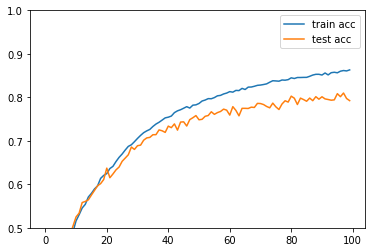

In [ ]:
plt.plot(train_acc_res,label='train acc')
plt.plot(test_acc_res,label='test acc')
plt.legend()
plt.ylim([0.5,1])
plt.show()

In [ ]:
train_acc_res, test_acc_res, train_loss_res, test_loss_res = train(resnet, trainloader, sgd, loss_func, 10)

Epoch 0: train loss: 596.9078, train acc: 0.872, test acc: 0.8084
Epoch 1: train loss: 602.0539, train acc: 0.873, test acc: 0.8055
Epoch 2: train loss: 593.2748, train acc: 0.871, test acc: 0.7979
Epoch 3: train loss: 590.3426, train acc: 0.872, test acc: 0.7997
Epoch 4: train loss: 580.9173, train acc: 0.874, test acc: 0.808
Epoch 5: train loss: 591.7177, train acc: 0.873, test acc: 0.8088
Epoch 6: train loss: 575.1690, train acc: 0.875, test acc: 0.803
Epoch 7: train loss: 577.0605, train acc: 0.876, test acc: 0.8049
Epoch 8: train loss: 576.3891, train acc: 0.876, test acc: 0.8078
Epoch 9: train loss: 565.6397, train acc: 0.879, test acc: 0.8036



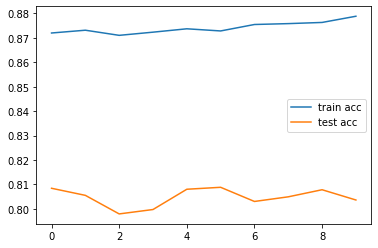

In [ ]:
plt.plot(train_acc_res,label='train acc')
plt.plot(test_acc_res,label='test acc')
plt.legend()
plt.show()